# Preprocessing Dual Energy Carbonate CT Data

Before running the Monte Carlo inversion, we need to perform some pre-configurations. 
In this tutorial, we will process this data directly within the Jupyter Notebook, 
in a parallel MPI environment using [ipyparallel](https://ipyparallel.readthedocs.io/).

Let's first create a cluster with a set of 5 MPI engines:

In [ ]:
import ipyparallel as ipp

# Create an MPI cluster with 8 engines
cluster = ipp.Cluster(engines="mpi", n=8)

# Start and connect to the cluster
rc = cluster.start_and_connect_sync()

# Enable IPython magics for parallel processing
rc[:].activate()


Starting 23 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/23 [00:00<?, ?engine/s]

This will enable the `%%px` 
[cell magic](https://ipyparallel.readthedocs.io/en/latest/examples/Parallel%20Magics.html#px-cell-magic), 
which allows RockVerse to perform parallel processing interactively within this Jupyter notebook.

Next, let's create the dual energy group and import the 
[raw images we downloaded from the Digital Rocks Portal](../sample_data/import_C04B21_dualenergy.ipynb):

In [2]:
%%px --block

#-------------- TROCAR CHUNK SHAPE -------#
import matplotlib.pyplot as plt
from IPython.display import display
import rockverse as rv

# Create the Dual Energy CT group
dectgroup = rv.dualenergyct.create_group(
    #store='/path/to/dual_energy_ct/C04B21',
    store='/estgf_dados/P_D/GOB7/testemunhos/C04B21_DGX',
    overwrite=True)

# Copy the low energy CT image
dectgroup.copy_image(
    #image=rv.open(store='/path/to/imported/dual_energy_carbonate/C04B21Raw100keV'),
    image=rv.open(store='/estgf_dados/P_D/GOB7/testemunhos/C04B21Raw100keV.zarr'),
    name='lowECT',
    chunks=16,
    overwrite=True)

# Copy the high energy CT image
dectgroup.copy_image(
    #image=rv.open(store='/path/to/imported/dual_energy_carbonate/C04B21Raw140keV'),
    image=rv.open(store='/estgf_dados/P_D/GOB7/testemunhos/C04B21Raw140keV.zarr'),
    name='highECT',
    chunks=16,
    overwrite=True)


%px:   0%|          | 0/23 [00:00<?, ?tasks/s]

[stdout:0] [2025-02-19 16:42:06] Copying: 100% 16/16 [00:03<00:00,  4.91chunk/s]
[2025-02-19 16:42:10] Copying: 100% 16/16 [00:03<00:00,  5.01chunk/s]


Now, let's take a quick look at the data using the orthogonal viewer:

[stdout:0] [2025-02-19 16:42:14] Histogram Low attenuation (min/max): 100% 16/16 [00:00<00:00, 210.24chunk/s]
[2025-02-19 16:42:14] Histogram Low attenuation (counting voxels): 100% 16/16 [00:02<00:00,  7.63chunk/s]
[2025-02-19 16:42:19] Histogram High attenuation (min/max): 100% 16/16 [00:00<00:00, 216.21chunk/s]
[2025-02-19 16:42:20] Histogram High attenuation (counting voxels): 100% 16/16 [00:00<00:00, 44.21chunk/s]


%px:   0%|          | 0/23 [00:00<?, ?tasks/s]

[output:0]

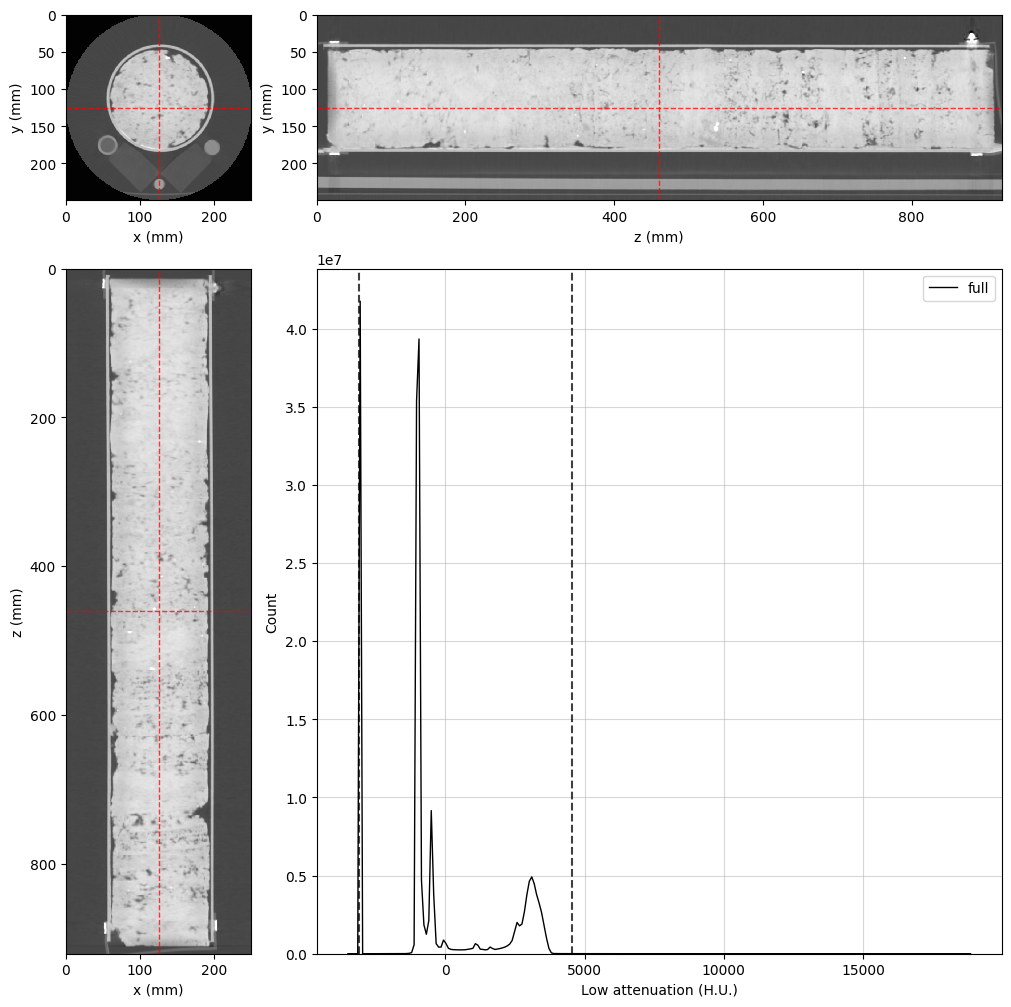

[output:0]

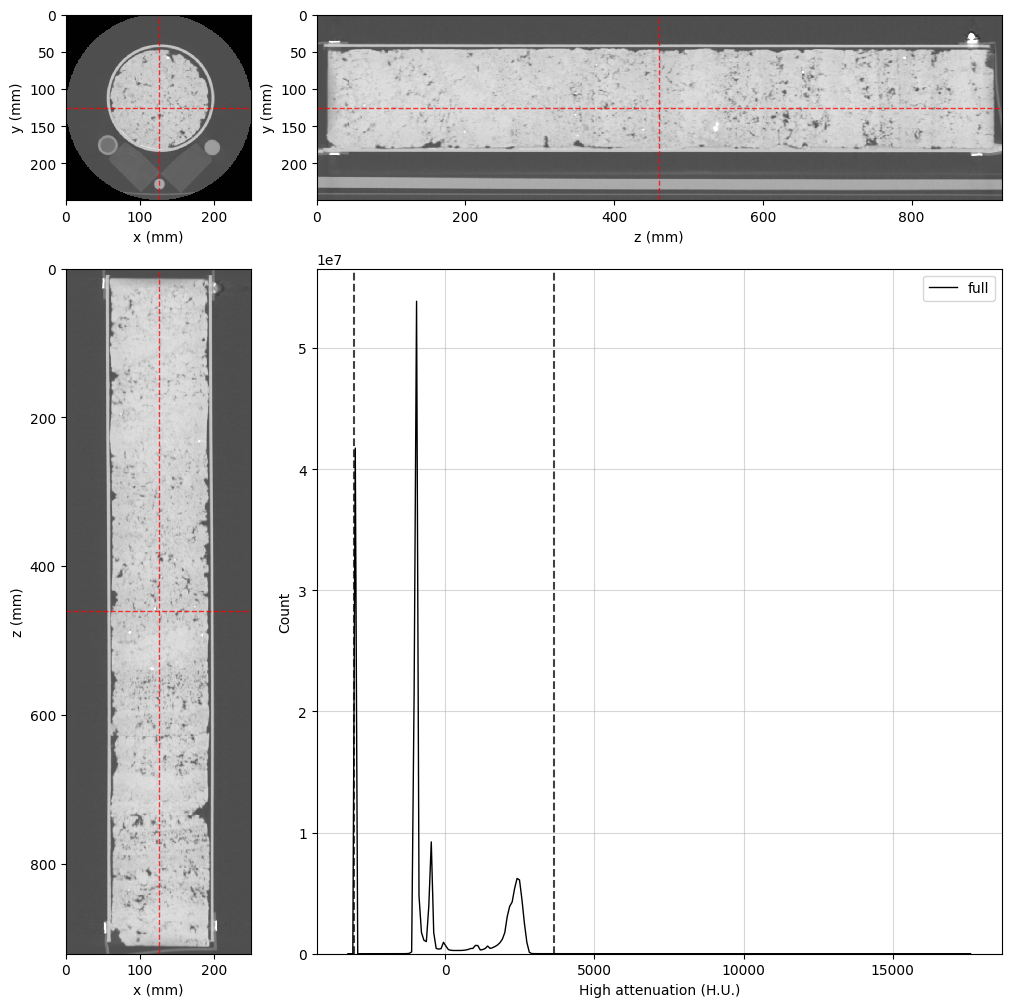

In [3]:
%%px --block

# Create orthogonal viewers for low and high energy images
lowE_viewer = rv.OrthogonalViewer(image=dectgroup.lowECT)
highE_viewer = rv.OrthogonalViewer(image=dectgroup.highECT)

# Matplotlib's figure object can be accessed through
# the figure property in the orthogonal viewer.
# Let's increase the figure size
lowE_viewer.figure.set_size_inches(10, 10)
highE_viewer.figure.set_size_inches(10, 10)

# Each process will create its own repeated image,
# let's close all but rank zero:
if rv.config.mpi_rank != 0:
    plt.close(lowE_viewer.figure)
    plt.close(highE_viewer.figure)


## Building the segmentation and mask images

We could use the ``copy_image`` method to bring segmentation and mask images 
into the ``dectgroup``, similar to what we just did with the X-ray tomograms 
(see the method documentation for details).

A segmentation image is used to inform RockVerse about the spatial location 
of the standard materials for histogram calculations. The mask image in the 
``dectgroup`` will instruct RockVerse to ignore masked voxels during the 
inversion process.

While the segmentation image is not available in the Digital Rocks Portal, 
the rock sample and the standard materials are fairly aligned with the image's 
z-axis. Let's quickly build a segmentation image using RockVerse's cylindrical 
regions.

A little trial and error is all it takes in this case:

### Air region

%px:   0%|          | 0/23 [00:00<?, ?tasks/s]

[stdout:0] [2025-02-19 16:42:29] Histogram High attenuation (min/max): 100% 16/16 [00:00<00:00, 33.16chunk/s]
[2025-02-19 16:42:30] Histogram High attenuation (counting voxels): 100% 16/16 [00:00<00:00, 122.09chunk/s]


[output:0]

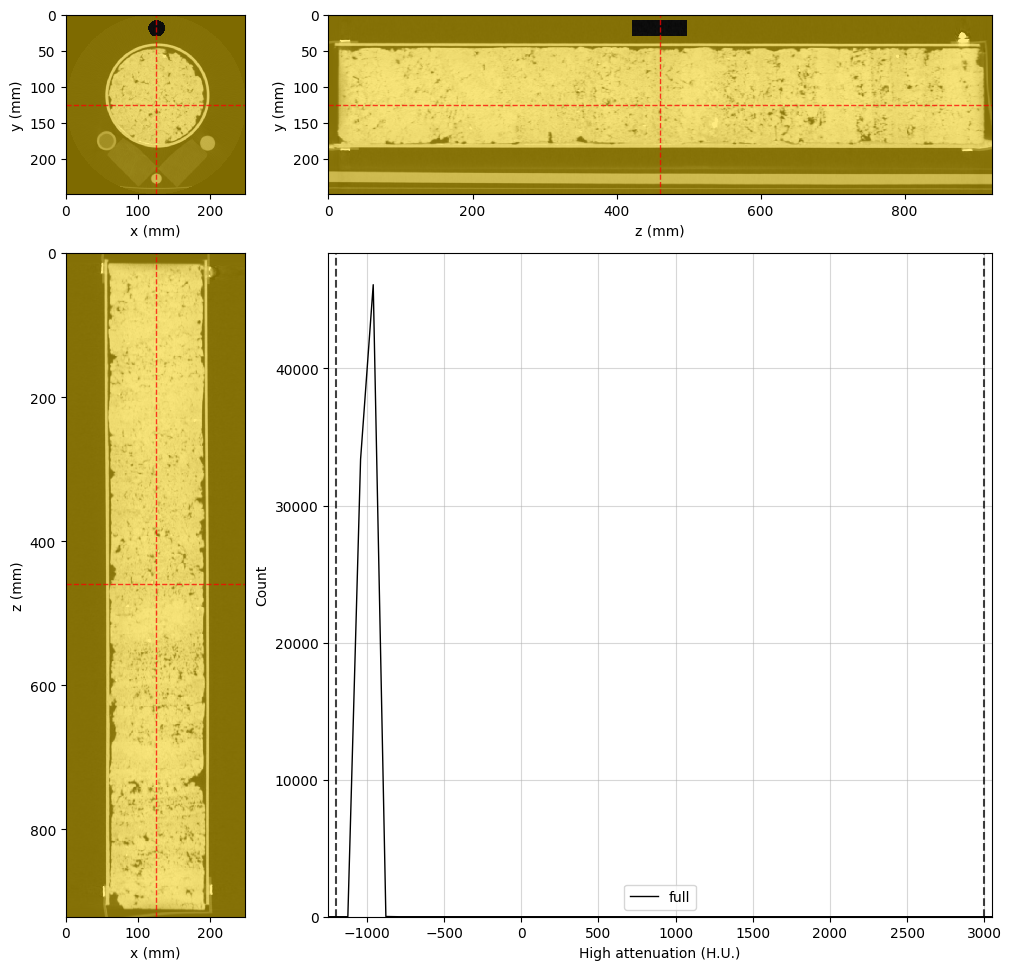

In [4]:
%%px --block

# Adjusting viewer properties will help us in this task
highE_viewer.update_image_dict(clim=(-1200, 3000))
highE_viewer.mask_color = 'gold'
highE_viewer.mask_alpha = 0.5

# This is the final cylindrical region for probing air attenuation
air_region = rv.region.Cylinder(p=(126, 20, 461), v=(0, 0, 1), r=10, l=750)
air_region = rv.region.Cylinder(p=(126, 20, 461), v=(0, 0, 1), r=10, l=75)

# Set the region in the viewer and visualize the result
highE_viewer.region = air_region

# Changing region rebuilds the histogram. Let's set the scale again
highE_viewer.ax_histogram.set_xlim(-1250, 3050)

# Only display the figure for rank 0
if rv.config.mpi_rank == 0:
    display(highE_viewer.figure)

### Water region

[stdout:0] [2025-02-19 16:42:34] Histogram High attenuation (min/max): 100% 16/16 [00:00<00:00, 35.77chunk/s]
[2025-02-19 16:42:34] Histogram High attenuation (counting voxels): 100% 16/16 [00:00<00:00, 119.68chunk/s]


%px:   0%|          | 0/23 [00:00<?, ?tasks/s]

[output:0]

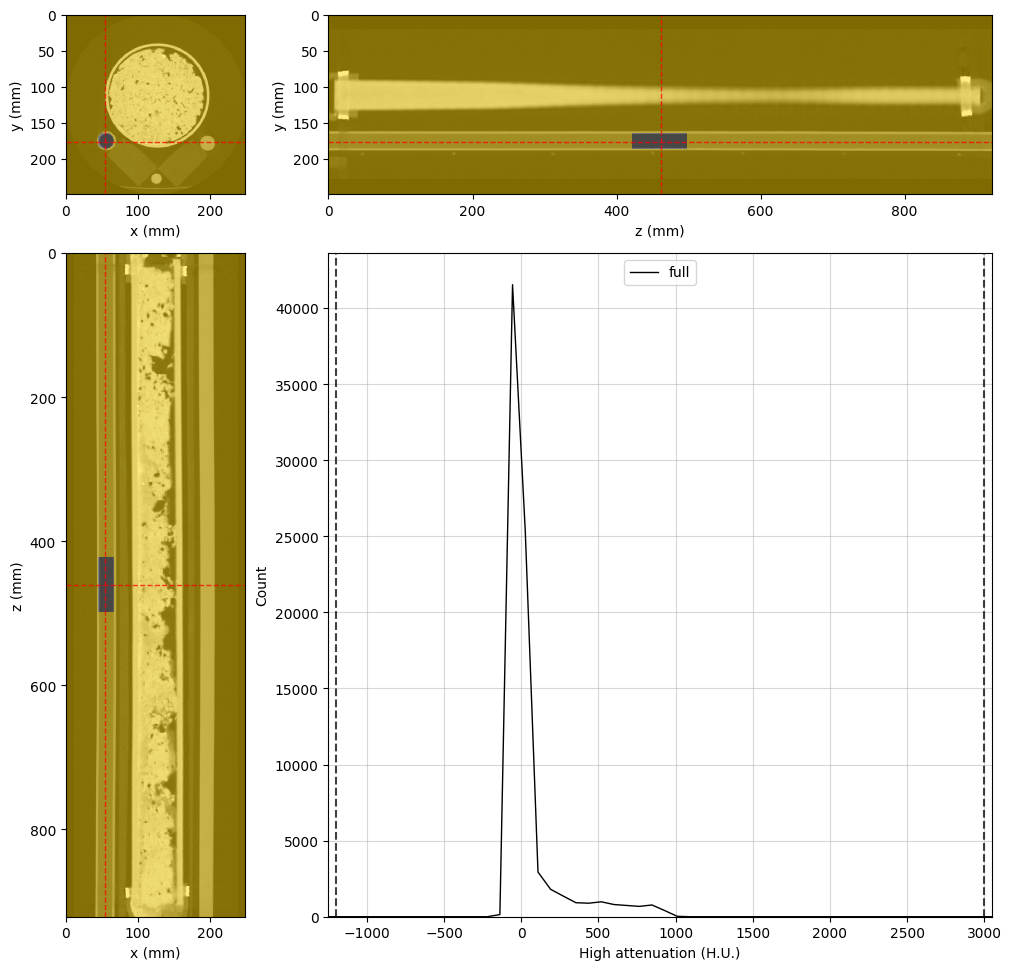

In [5]:
%%px --block

# Final water region
water_region = rv.region.Cylinder(p=(55, 176.2, 461), v=(0, 0, 1), r=10, l=900)
water_region = rv.region.Cylinder(p=(55, 176.2, 461), v=(0, 0, 1), r=10, l=75)

# Adjust the viewer and display for rank 0
highE_viewer.region = water_region
highE_viewer.ref_point = water_region.p
highE_viewer.ax_histogram.set_xlim(-1250, 3050)

if rv.config.mpi_rank == 0:
    display(highE_viewer.figure)

### Silica region

[stdout:0] [2025-02-19 16:42:38] Histogram High attenuation (min/max): 100% 16/16 [00:00<00:00, 26.84chunk/s]
[2025-02-19 16:42:39] Histogram High attenuation (counting voxels): 100% 16/16 [00:00<00:00, 120.27chunk/s]


%px:   0%|          | 0/23 [00:00<?, ?tasks/s]

[output:0]

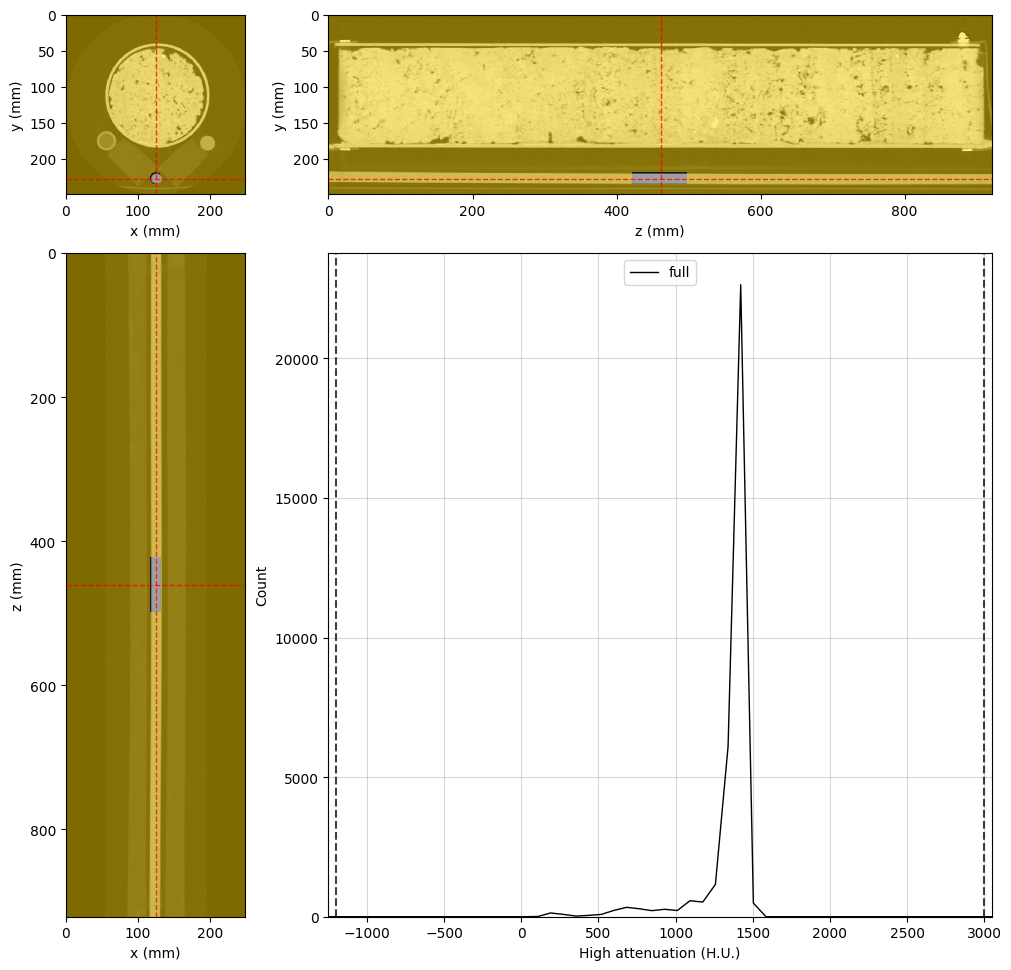

In [6]:
%%px --block

# Final silica region
silica_region = rv.region.Cylinder(p=(124.7, 228, 461), v=(0, 0, 1), r=6.5, l=900)
silica_region = rv.region.Cylinder(p=(124.7, 228, 461), v=(0, 0, 1), r=6.5, l=75)

# Adjust the viewer and display for rank 0
highE_viewer.region = silica_region
highE_viewer.ref_point = silica_region.p
highE_viewer.ax_histogram.set_xlim(-1250, 3050)

if rv.config.mpi_rank == 0:
    display(highE_viewer.figure)

### Teflon region

[stdout:0] [2025-02-19 16:42:43] Histogram High attenuation (min/max): 100% 16/16 [00:00<00:00, 35.56chunk/s]
[2025-02-19 16:42:44] Histogram High attenuation (counting voxels): 100% 16/16 [00:00<00:00, 121.13chunk/s]


%px:   0%|          | 0/23 [00:00<?, ?tasks/s]

[output:0]

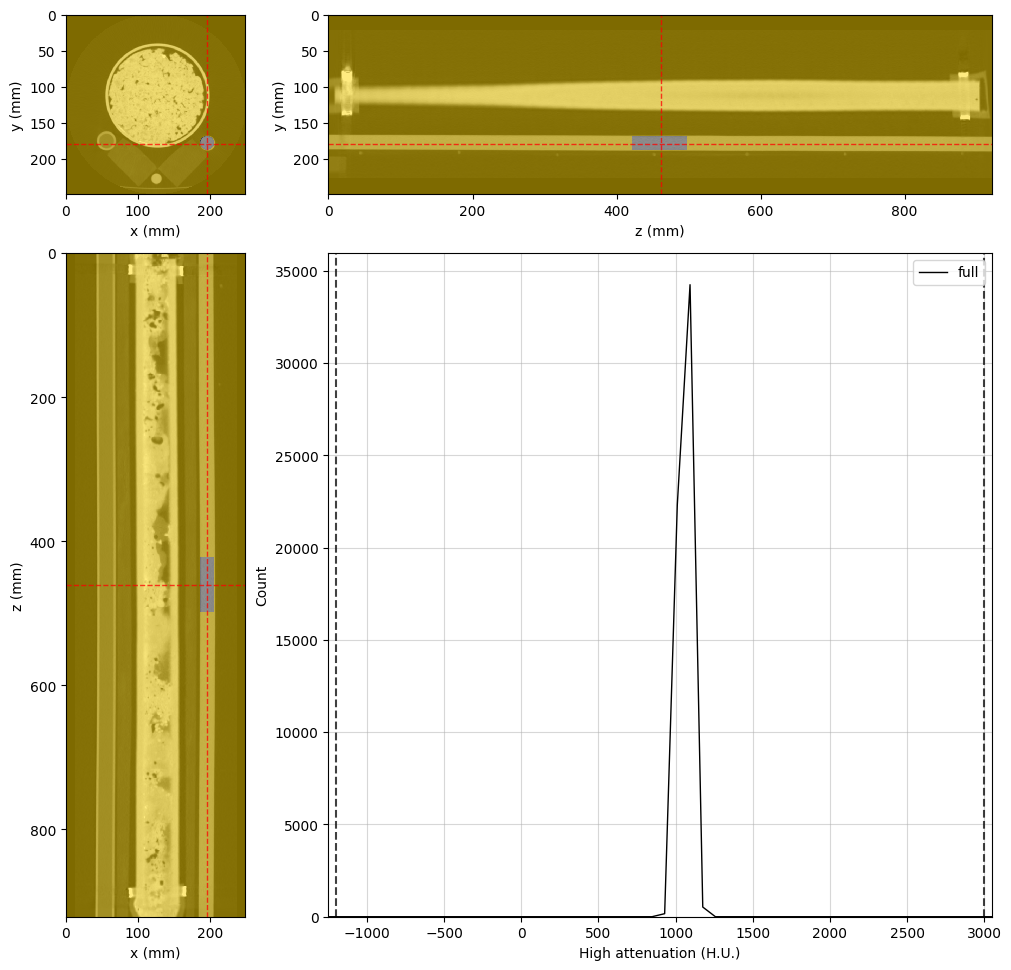

In [7]:
%%px --block

# Final teflon region
teflon_region = rv.region.Cylinder(p=(196, 179, 461), v=(0, 0, 1), r=8.5, l=900)
teflon_region = rv.region.Cylinder(p=(196, 179, 461), v=(0, 0, 1), r=8.5, l=75)

# Adjust the viewer and display for rank 0
highE_viewer.region = teflon_region
highE_viewer.ref_point = teflon_region.p
highE_viewer.ax_histogram.set_xlim(-1250, 3050)

if rv.config.mpi_rank == 0:
    display(highE_viewer.figure)

### Rock sample region

[stdout:0] [2025-02-19 16:42:48] Histogram High attenuation (min/max): 100% 16/16 [00:00<00:00, 37.72chunk/s]
[2025-02-19 16:42:49] Histogram High attenuation (counting voxels): 100% 16/16 [00:00<00:00, 121.02chunk/s]


%px:   0%|          | 0/23 [00:00<?, ?tasks/s]

[output:0]

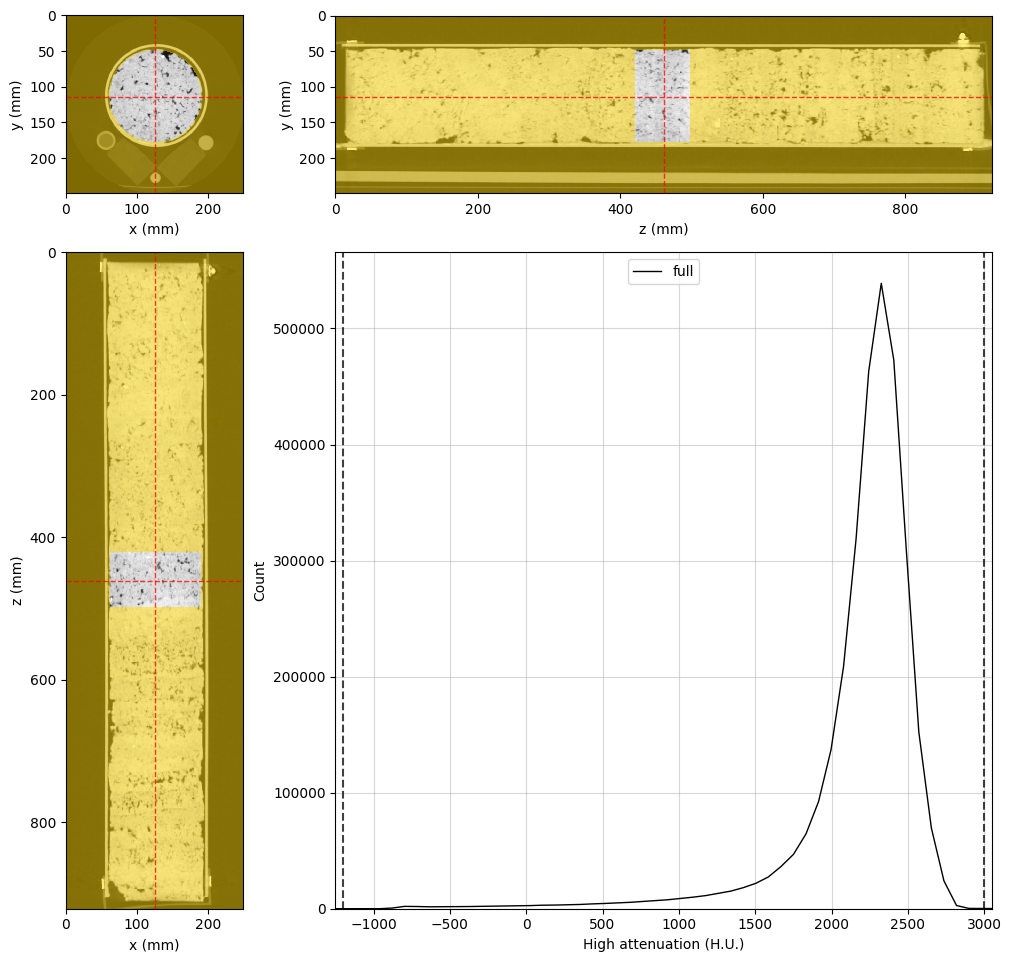

In [8]:
%%px --block --group-outputs=type

# Final rock region
rock_region = rv.region.Cylinder(p=(126, 114, 461), v=(0, 0, 1), r=63, l=875)
rock_region = rv.region.Cylinder(p=(126, 114, 461), v=(0, 0, 1), r=63, l=75)

# Adjust the viewer and display for rank 0
highE_viewer.region = rock_region
highE_viewer.ref_point = rock_region.p
highE_viewer.ax_histogram.set_xlim(-1250, 3050)

if rv.config.mpi_rank == 0:
    display(highE_viewer.figure)

### Combined segmentation image

Now, we can use these regions to create the final segmentation image:

[stdout:0] [2025-02-19 16:42:53] (segmentation) Set: 100% 16/16 [00:05<00:00,  3.09chunk/s]
[2025-02-19 16:43:01] (segmentation) Set: 100% 16/16 [00:00<00:00, 54.01chunk/s]
[2025-02-19 16:43:02] (segmentation) Set: 100% 16/16 [00:00<00:00, 52.95chunk/s]
[2025-02-19 16:43:03] (segmentation) Set: 100% 16/16 [00:00<00:00, 52.85chunk/s]
[2025-02-19 16:43:03] (segmentation) Set: 100% 16/16 [00:00<00:00, 54.83chunk/s]
[2025-02-19 16:43:03] Histogram High attenuation (min/max): 100% 16/16 [00:00<00:00, 151.30chunk/s]
[2025-02-19 16:43:03] Histogram High attenuation (counting voxels): 100% 16/16 [00:00<00:00, 44.03chunk/s]
[2025-02-19 16:43:05] Histogram High attenuation (min/max): 100% 16/16 [00:00<00:00, 161.69chunk/s]
[2025-02-19 16:43:06] Histogram High attenuation (reading segmentation): 100% 16/16 [00:00<00:00, 128.64chunk/s]
[2025-02-19 16:43:06] Histogram High attenuation (counting voxels): 100% 16/16 [00:00<00:00, 19.90chunk/s]


%px:   0%|          | 0/23 [00:00<?, ?tasks/s]

[output:0]

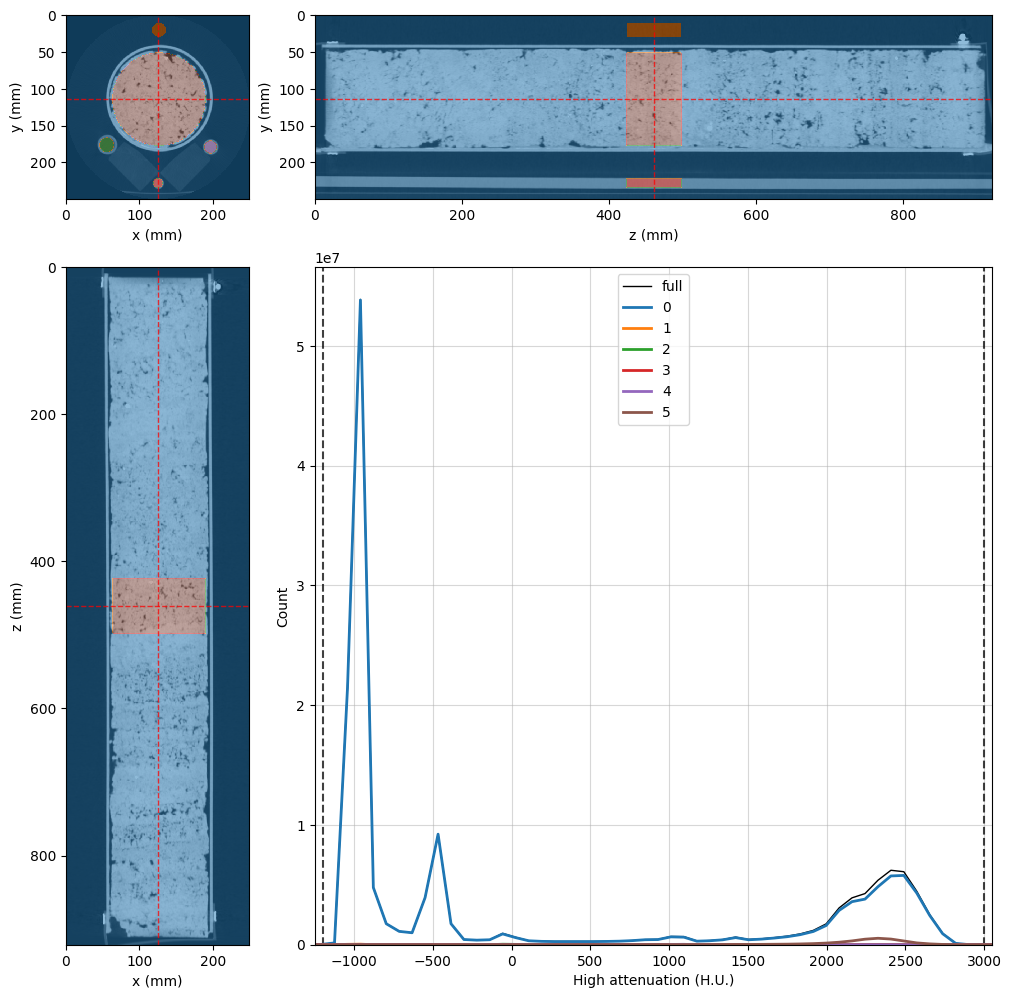

In [9]:
%%px --block

# Create the segmentation voxel image inside the dual energy group
dectgroup.create_segmentation(fill_value=0, overwrite=True)

# Use the VoxelImage math method to assign each region
dectgroup.segmentation.math(value=1, op='set', region=air_region)     # Air
dectgroup.segmentation.math(value=2, op='set', region=water_region)   # Water
dectgroup.segmentation.math(value=3, op='set', region=silica_region)  # Silica
dectgroup.segmentation.math(value=4, op='set', region=teflon_region)  # Teflon
dectgroup.segmentation.math(value=5, op='set', region=rock_region)    # Rock sample

# Adjust the viewer and display for rank 0
highE_viewer.region = None
highE_viewer.segmentation = dectgroup.segmentation
highE_viewer.ref_point = rock_region.p
highE_viewer.ax_histogram.set_xlim(-1250, 3050)

if rv.config.mpi_rank == 0:
    display(highE_viewer.figure)

### Adjusting histogram bins

It is clear from the image that the default value for the number of histogram bins results in a crude histogram. We need to calculate a more detailed histogram, as the histogram counts will serve as the basis for calculating the probability density functions for the X-ray attenuation values in the standard materials.

Once again, some testing led to the final choice of $2^{10}$ bins. Let's update our DECT group and our viewer:

[stdout:0] [2025-02-19 16:43:11] Histogram High attenuation (min/max): 100% 16/16 [00:00<00:00, 145.77chunk/s]
[2025-02-19 16:43:11] Histogram High attenuation (reading segmentation): 100% 16/16 [00:00<00:00, 980.15chunk/s]
[2025-02-19 16:43:11] Histogram High attenuation (counting voxels): 100% 16/16 [00:00<00:00, 16.48chunk/s]


%px:   0%|          | 0/23 [00:00<?, ?tasks/s]

[output:0]

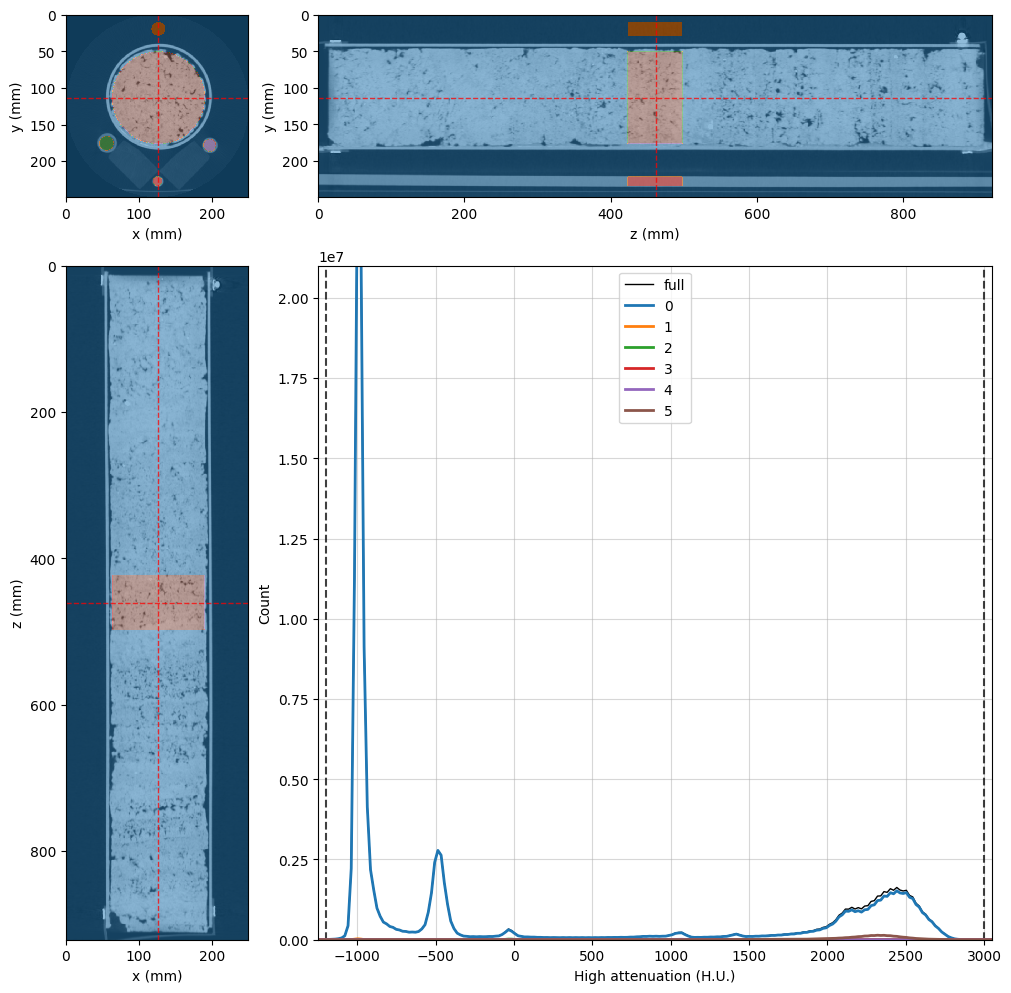

In [10]:
%%px --block

# Set the new number of histogram bins
highE_viewer.histogram_bins = 2**10

# Fix the plot scale, as the previous line triggers new histogram calculation
highE_viewer.ax_histogram.set_xlim(-1250, 3050)
highE_viewer.ax_histogram.set_ylim(0, 2.1e7)

if rv.config.mpi_rank == 0:
    display(highE_viewer.figure)

### Mask Image

Now let's define an image mask to save time in the Monte Carlo inversion by masking out voxels for which we are not interested in the results. While we cannot assign RockVerse regions of interest to DualEnergyCT groups, we can create an arbitrary mask voxel image to inform RockVerse which voxels should be ignored.

If you have a mask image somewhere, you can import it into the ``dualenergyct`` group using the ``copy_image`` method. In our case, phase 0 in our segmentation image represents the regions we want to exclude from our inversion, so the ``create_mask`` method is all we need:


[stdout:0] [2025-02-19 16:43:15] (mask) Set: 100% 16/16 [00:01<00:00,  8.05chunk/s]
[2025-02-19 16:43:17] Histogram High attenuation (min/max): 100% 16/16 [00:00<00:00, 50.66chunk/s]
[2025-02-19 16:43:17] Histogram High attenuation (reading segmentation): 100% 16/16 [00:00<00:00, 1017.39chunk/s]
[2025-02-19 16:43:17] Histogram High attenuation (counting voxels): 100% 16/16 [00:00<00:00, 118.85chunk/s]


%px:   0%|          | 0/23 [00:00<?, ?tasks/s]

[output:0]

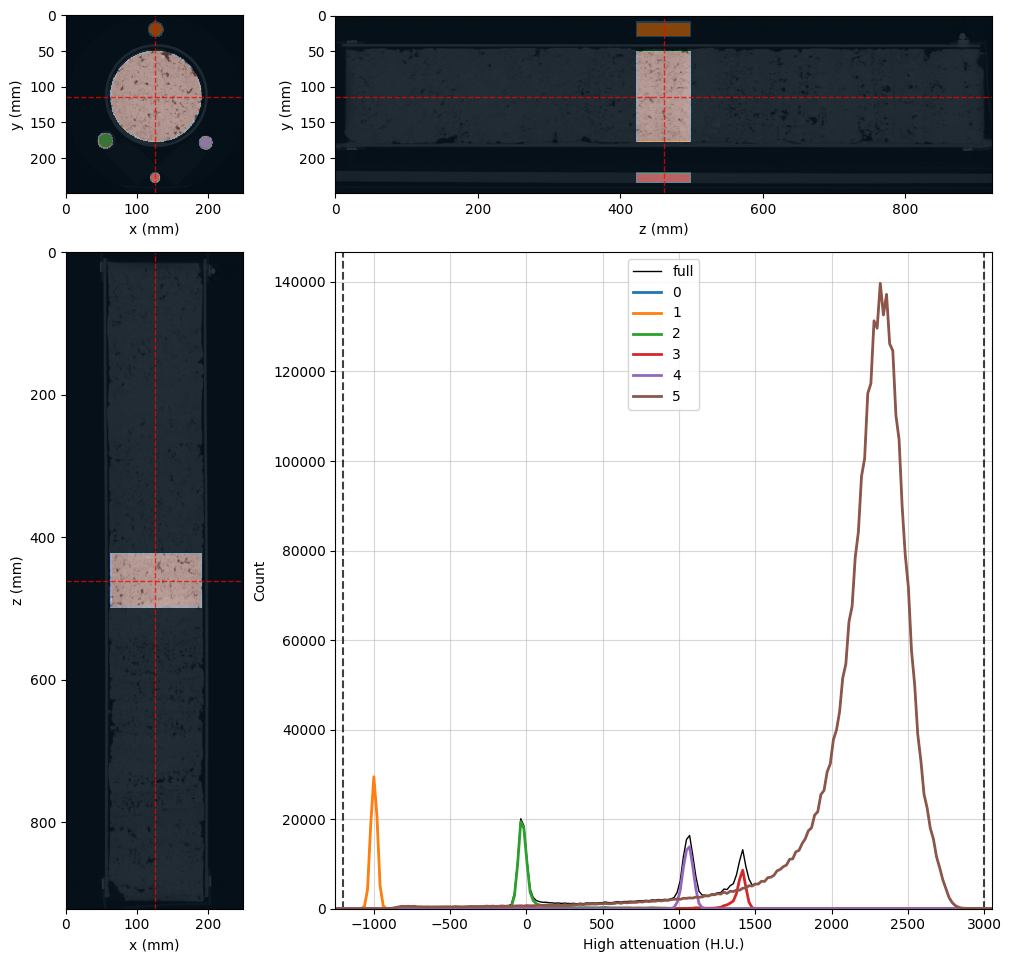

In [11]:
%%px --block

# Create the empty mask
dectgroup.create_mask(fill_value=False, overwrite=True)

# Use VoxelImage math method to set mask to True where segmentation is 0
dectgroup.mask.math(value=True,
                    op='set',
                    segmentation=dectgroup.segmentation,
                    phases=(0,))

# Adjust the viewer and display for rank 0
highE_viewer.mask = dectgroup.mask
highE_viewer.mask_color = 'k'
highE_viewer.mask_alpha = 0.75
highE_viewer.ax_histogram.set_xlim(-1250, 3050)

if rv.config.mpi_rank == 0:
    display(highE_viewer.figure)


The black voxels in the image above will be ignored during the Monte Carlo inversion. Let's rebuild both viewers with all the updates so far:

[stdout:0] [2025-02-19 16:43:24] Histogram Low attenuation (min/max): 100% 16/16 [00:00<00:00, 81.61chunk/s]
[2025-02-19 16:43:24] Histogram Low attenuation (reading segmentation): 100% 16/16 [00:00<00:00, 1000.16chunk/s]
[2025-02-19 16:43:24] Histogram Low attenuation (counting voxels): 100% 16/16 [00:00<00:00, 119.01chunk/s]
[2025-02-19 16:43:28] Histogram High attenuation (min/max): 100% 16/16 [00:00<00:00, 98.22chunk/s]
[2025-02-19 16:43:28] Histogram High attenuation (reading segmentation): 100% 16/16 [00:00<00:00, 1011.10chunk/s]
[2025-02-19 16:43:28] Histogram High attenuation (counting voxels): 100% 16/16 [00:00<00:00, 121.41chunk/s]


%px:   0%|          | 0/23 [00:00<?, ?tasks/s]

[output:0]

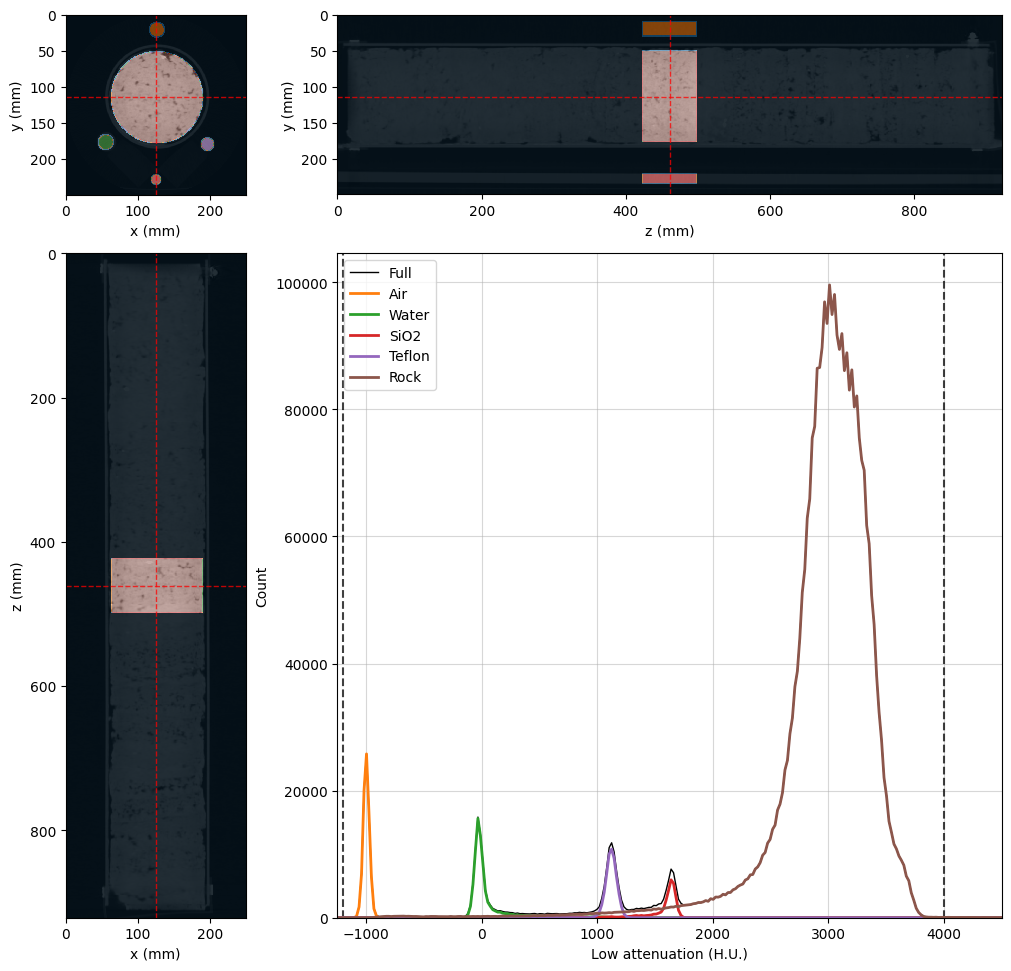

[output:0]

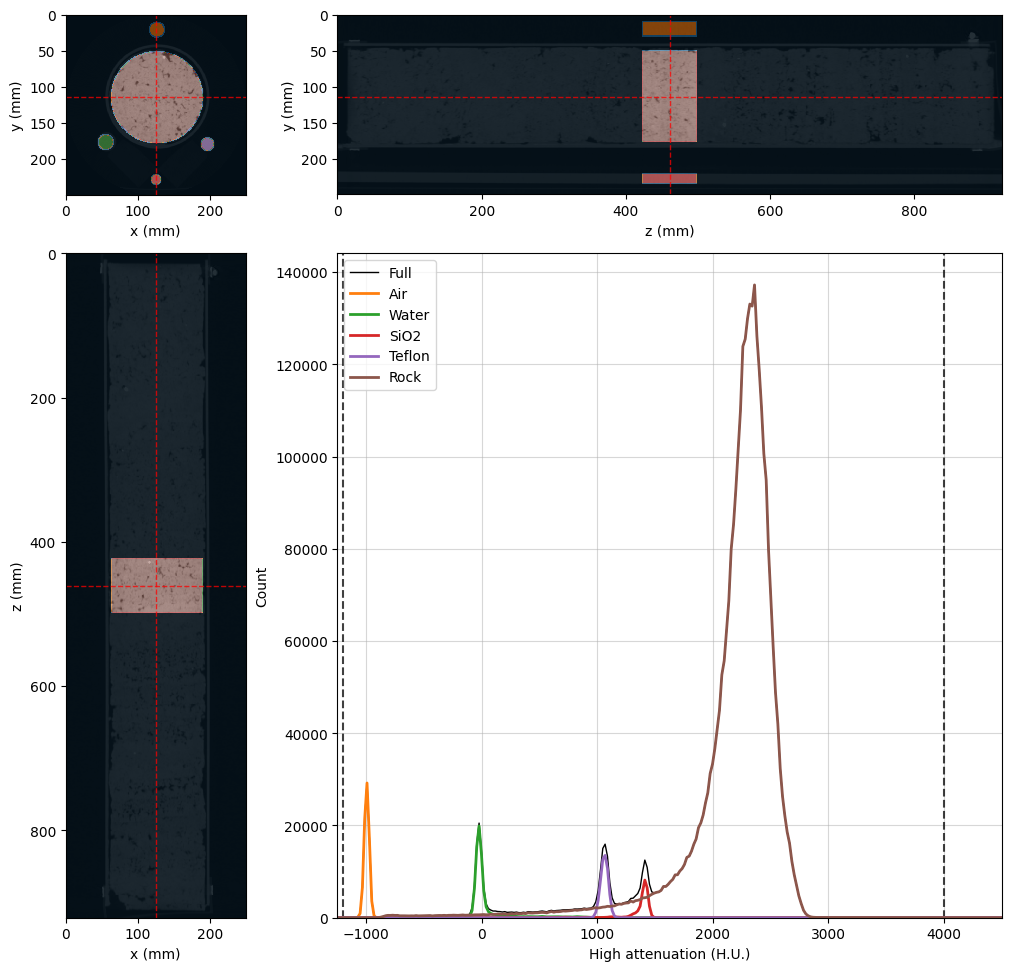

In [12]:
%%px --block

# Common properties can be set at once at OrthogonalViewer creation
kwargs = {
    'region': None,
    'mask': dectgroup.mask,
    'mask_color': 'k',
    'mask_alpha': 0.75,
    'histogram_bins': 2**10,
    'segmentation': dectgroup.segmentation,
    'ref_point': rock_region.p,
}

lowE_viewer = rv.OrthogonalViewer(image=dectgroup.lowECT, **kwargs)
highE_viewer = rv.OrthogonalViewer(image=dectgroup.highECT, **kwargs)

# Fine tuning
for viewer in [lowE_viewer, highE_viewer]:
    viewer.figure.set_size_inches(10, 10)    # figure size
    viewer.update_image_dict(clim=(-1200, 4000)) # X-ray CT clims
    viewer.ax_histogram.set_xlim(-1250, 4500)  # Histogram limits
    # Set segmentation names in the legend labels
    viewer.ax_histogram.legend(
        [
            highE_viewer.histogram_lines['full'],
            highE_viewer.histogram_lines['1'],
            highE_viewer.histogram_lines['2'],
            highE_viewer.histogram_lines['3'],
            highE_viewer.histogram_lines['4'],
            highE_viewer.histogram_lines['5'],
        ], [
            'Full',
            'Air',
            'Water',
            'SiO2',
            'Teflon',
            'Rock'
        ]
    )

# Close all but rank 0
if rv.config.mpi_rank != 0:
    plt.close(lowE_viewer.figure)
    plt.close(highE_viewer.figure)



## Filling Standard Material Information

The next step is to populate the information and the X-ray attenuation probability density functions (PDF) for the standard materials. The PDFs have to be passed as a two-element list or tuple with the x (attenuation values) and y (pdf values) arrays for the pdf model. 
PDF values do not need to be normalized, as RockVerse will take care of the normalization when assigning the values.

We could use the histogram values themselves, but due to our lazy segmentation in this tutorial, we'll model a Gaussian distribution after each segmentation histogram to filter out spurious values and border voxels. We'll use the RockVerse optimization module for this task.

### Air

%px:   0%|          | 0/23 [00:00<?, ?tasks/s]

[output:0]

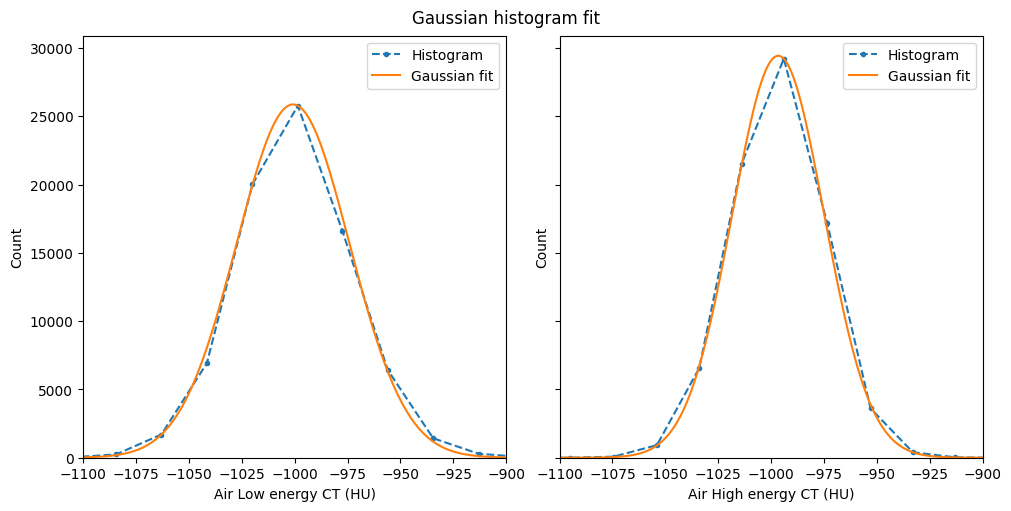

[output:0]

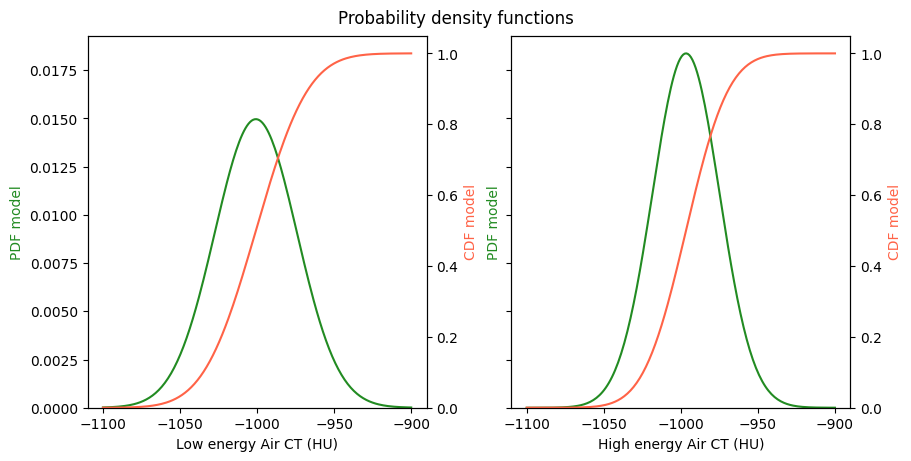

In [13]:
%%px --block

import numpy as np
from rockverse.optimize import gaussian_fit, gaussian_val

seg_phase = 1  # Air is segmentation phase 1
cm_index = 0   # Standard material 0 is empty space
name = 'Air'

x_low = lowE_viewer.histogram.bin_centers
y_low = lowE_viewer.histogram.count[seg_phase].values
x_high = highE_viewer.histogram.bin_centers
y_high = highE_viewer.histogram.count[seg_phase].values

# Call gaussian_fit to get fitting parameters
c_low = gaussian_fit(x_low, y_low)
c_high = gaussian_fit(x_high, y_high)

# We'll build a fine-spaced histogram axis and call
# gaussian_val to build the gaussian curve.
# It is important sample regions
# with PDF values close to zero
xlim = (-1100, -900)
x_fit = np.linspace(*xlim, 200)
y_fit_low = gaussian_val(c_low, x_fit)
y_fit_high = gaussian_val(c_high, x_fit)

# Let's check the Gaussian fit:
if mpi_rank == 0:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5),
                            layout='constrained',
                            sharex=True, sharey=True)
    fig.suptitle('Gaussian histogram fit')

    for k, (x, y, yfit, E) in enumerate(zip((x_low, x_high),
                                             (y_low, y_high),
                                             (y_fit_low, y_fit_high),
                                             ('Low', 'High'))):

        ax[k].plot(x, y, '.--', label='Histogram')
        ax[k].plot(x_fit, yfit, '-', label='Gaussian fit')
        ax[k].set_xlabel(f'{name} {E} energy CT (HU)')
        ax[k].set_xlim(xlim)
        ax[k].legend()
        ax[k].set_ylabel('Count')
    ax[0].set_ylim(ymin=0)

# Now fill in necessary fields in dectgroup
# Note: setting or getting PDFs is a collective MPI call,
# make sure all the processes run it (e.g. don't use if 'mpi_rank == 0')
dectgroup.calibration_material[cm_index].description = name
dectgroup.calibration_material[cm_index].lowE_pdf = (x_fit, y_fit_low)
dectgroup.calibration_material[cm_index].highE_pdf = (x_fit, y_fit_high)

# RockVerse will normalize the pdf values before assigning them.
# Let's check that also (again, make sure all processes run these four lines)
x_lowE_pdf, y_lowE_pdf = dectgroup.calibration_material[cm_index].lowE_pdf
x_highE_pdf, y_highE_pdf = dectgroup.calibration_material[cm_index].highE_pdf

#Cumulative density function (CDF) is also available
_, cdf_low = dectgroup.calibration_material[cm_index].lowE_cdf
_, cdf_high = dectgroup.calibration_material[cm_index].highE_cdf

if rv.config.mpi_rank == 0:
    fig, ax = plt.subplots(1, 2, figsize=(9, 4.5),
                            layout='constrained',
                            sharex=True, sharey=True)
    fig.suptitle('Probability density functions')

    for k, (x, y, c, E) in enumerate(zip((x_lowE_pdf, x_highE_pdf),
                                         (y_lowE_pdf, y_highE_pdf),
                                         (cdf_low, cdf_high),
                                         ('Low', 'High'))):
        ax[k].plot(x, y, color='forestgreen')
        ax[k].set_xlabel(f'{E} energy Air CT (HU)')
        ax[k].set_ylabel('PDF model', color='forestgreen')
        ax_cdf = ax[k].twinx()
        ax_cdf.plot(x, c, color='tomato')
        ax_cdf.set_ylabel('CDF model', color='tomato')
        ax_cdf.set_ylim(ymin=0)
    ax[0].set_ylim(ymin=0)


Now let's replicate to the other standard materials.

### Water

%px:   0%|          | 0/23 [00:00<?, ?tasks/s]

[output:0]

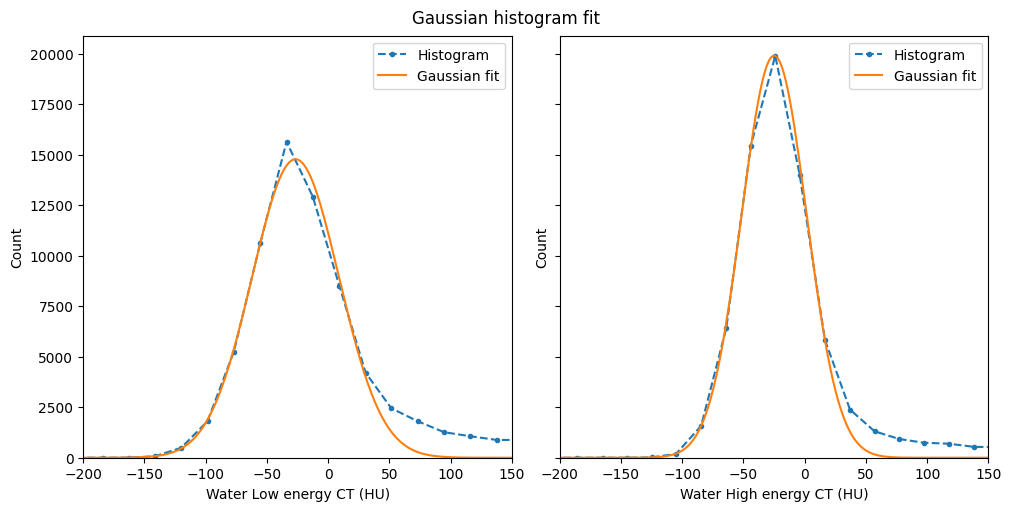

[output:0]

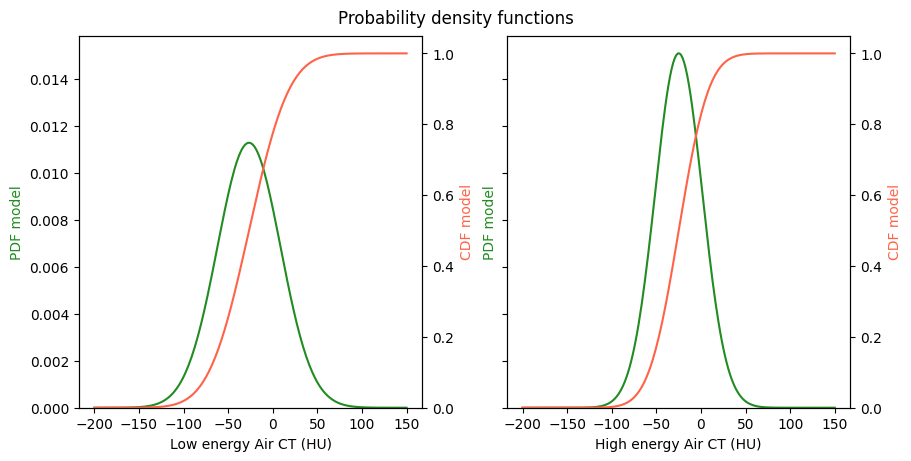

In [14]:
%%px --block

seg_phase = 2 # Water is segmentation phase 1
cm_index = 1  # We'll assign water to calibration material 1
name = 'Water'
bulk_density = 1.
composition = {'H': 2, 'O': 1}

x_low = lowE_viewer.histogram.bin_centers
y_low = lowE_viewer.histogram.count[seg_phase].values
x_high = highE_viewer.histogram.bin_centers
y_high = highE_viewer.histogram.count[seg_phase].values

# Call gaussian_fit to get fitting parameters
c_low = gaussian_fit(x_low, y_low)
c_high = gaussian_fit(x_high, y_high)

# Build a fine-spaced histogram axis and call
# gaussian_val to build the gaussian curve.
# It is important sample regions
# with PDF values close to zero
xlim = (-200, 150)
x_fit = np.linspace(*xlim, 200)
y_fit_low = gaussian_val(c_low, x_fit)
y_fit_high = gaussian_val(c_high, x_fit)

# Let's check the Gaussian fit:
if mpi_rank == 0:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5),
                           layout='constrained',
                           sharex=True, sharey=True)
    fig.suptitle('Gaussian histogram fit')

    for k, (x, y, yfit, E) in enumerate(zip((x_low, x_high),
                                            (y_low, y_high),
                                            (y_fit_low, y_fit_high),
                                            ('Low', 'High'))):

        ax[k].plot(x, y, '.--', label='Histogram')
        ax[k].plot(x_fit, yfit, '-', label='Gaussian fit')
        ax[k].set_xlabel(f'{name} {E} energy CT (HU)')
        ax[k].set_xlim(xlim)
        ax[k].legend()
        ax[k].set_ylabel('Count')
    ax[0].set_ylim(ymin=0)

# Now fill in necessary fields in dectgroup
# Note: setting or getting PDFs is a collective MPI call,
# make sure all the processes run it (e.g. don't use if 'mpi_rank == 0')
dectgroup.calibration_material[cm_index].description = name
dectgroup.calibration_material[cm_index].lowE_pdf = (x_fit, y_fit_low)
dectgroup.calibration_material[cm_index].highE_pdf = (x_fit, y_fit_high)
dectgroup.calibration_material[cm_index].bulk_density = bulk_density
dectgroup.calibration_material[cm_index].composition = composition

# RockVerse will normalize the PDF values before assigning them.
# Let's check that also (again, make sure all processes run these four lines)
x_lowE_pdf, y_lowE_pdf = dectgroup.calibration_material[cm_index].lowE_pdf
_, cdf_low = dectgroup.calibration_material[cm_index].lowE_cdf
x_highE_pdf, y_highE_pdf = dectgroup.calibration_material[cm_index].highE_pdf
_, cdf_high = dectgroup.calibration_material[cm_index].highE_cdf

if rv.config.mpi_rank == 0:
    fig, ax = plt.subplots(1, 2, figsize=(9, 4.5),
                           layout='constrained',
                           sharex=True, sharey=True)
    fig.suptitle('Probability density functions')

    for k, (x, y, c, E) in enumerate(zip((x_lowE_pdf, x_highE_pdf),
                                         (y_lowE_pdf, y_highE_pdf),
                                         (cdf_low, cdf_high),
                                         ('Low', 'High'))):
        ax[k].plot(x, y, color='forestgreen')
        ax[k].set_xlabel(f'{E} energy Air CT (HU)')
        ax[k].set_ylabel('PDF model', color='forestgreen')
        ax_cdf = ax[k].twinx()
        ax_cdf.plot(x, c, color='tomato')
        ax_cdf.set_ylabel('CDF model', color='tomato')
        ax_cdf.set_ylim(ymin=0)
    ax[0].set_ylim(ymin=0)

### Silica

[output:0]

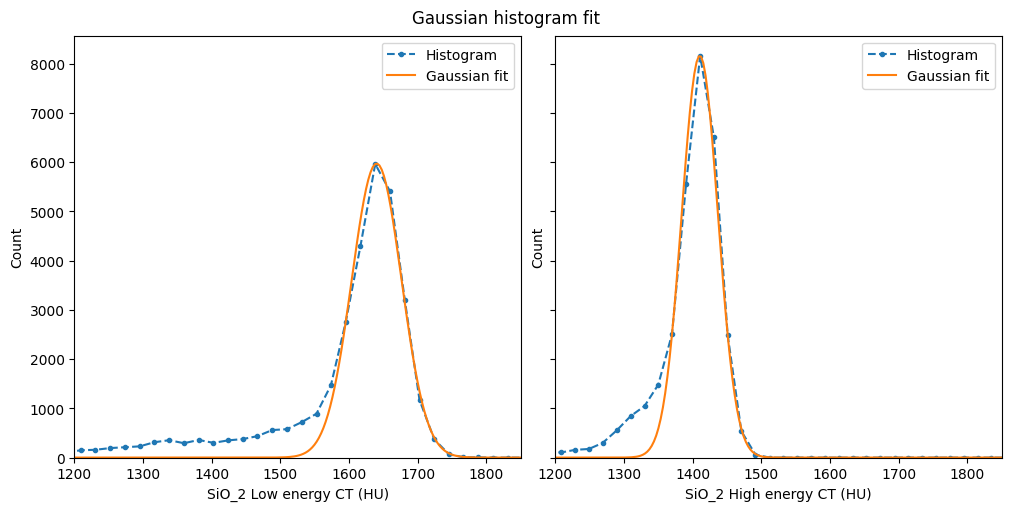

[output:0]

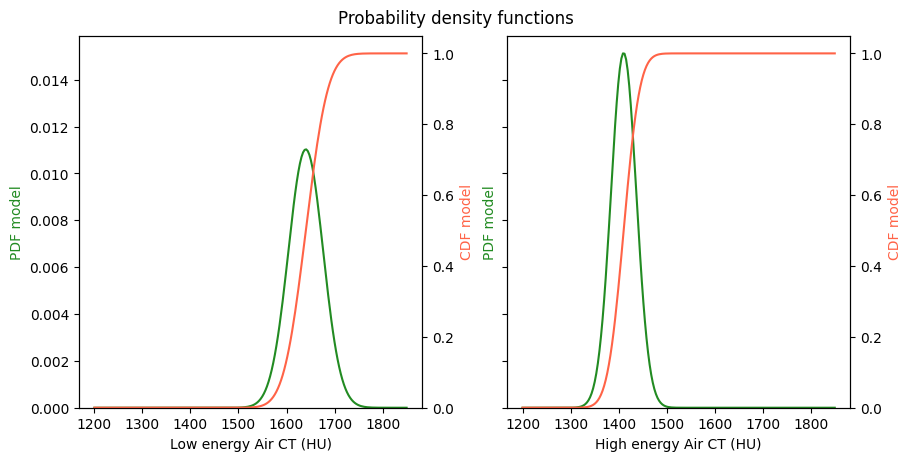

In [15]:
%%px --block

seg_phase = 3 # Silica is segmentation phase 3
cm_index = 2  # We'll assign silica to calibration material 2
name = 'SiO_2'
bulk_density = 2.2
composition = {'Si': 1, 'O': 2}

x_low = lowE_viewer.histogram.bin_centers
y_low = lowE_viewer.histogram.count[seg_phase].values
x_high = highE_viewer.histogram.bin_centers
y_high = highE_viewer.histogram.count[seg_phase].values

# Call gaussian_fit to get fitting parameters
c_low = gaussian_fit(x_low, y_low)
c_high = gaussian_fit(x_high, y_high)

# Build a fine-spaced histogram axis and call
# gaussian_val to build the gaussian curve.
# It is important to sample regions
# with PDF values close to zero
xlim = (1200, 1850)
x_fit = np.linspace(*xlim, 200)
y_fit_low = gaussian_val(c_low, x_fit)
y_fit_high = gaussian_val(c_high, x_fit)

# Let's check the Gaussian fit:
if mpi_rank == 0:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5),
                           layout='constrained',
                           sharex=True, sharey=True)
    fig.suptitle('Gaussian histogram fit')

    for k, (x, y, yfit, E) in enumerate(zip((x_low, x_high),
                                            (y_low, y_high),
                                            (y_fit_low, y_fit_high),
                                            ('Low', 'High'))):

        ax[k].plot(x, y, '.--', label='Histogram')
        ax[k].plot(x_fit, yfit, '-', label='Gaussian fit')
        ax[k].set_xlabel(f'{name} {E} energy CT (HU)')
        ax[k].set_xlim(xlim)
        ax[k].legend()
        ax[k].set_ylabel('Count')
    ax[0].set_ylim(ymin=0)

# Now fill in necessary fields in dectgroup
# Note: setting or getting PDFs is a collective MPI call,
# make sure all the processes run it (e.g. don't use if 'mpi_rank == 0')
dectgroup.calibration_material[cm_index].description = name
dectgroup.calibration_material[cm_index].lowE_pdf = (x_fit, y_fit_low)
dectgroup.calibration_material[cm_index].highE_pdf = (x_fit, y_fit_high)
dectgroup.calibration_material[cm_index].bulk_density = bulk_density
dectgroup.calibration_material[cm_index].composition = composition

# RockVerse will normalize the PDF values before assigning them.
# Let's check that also (again, make sure all processes run these four lines)
x_lowE_pdf, y_lowE_pdf = dectgroup.calibration_material[cm_index].lowE_pdf
x_highE_pdf, y_highE_pdf = dectgroup.calibration_material[cm_index].highE_pdf
_, cdf_low = dectgroup.calibration_material[cm_index].lowE_cdf
_, cdf_high = dectgroup.calibration_material[cm_index].highE_cdf

if rv.config.mpi_rank == 0:
    fig, ax = plt.subplots(1, 2, figsize=(9, 4.5),
                           layout='constrained',
                           sharex=True, sharey=True)
    fig.suptitle('Probability density functions')

    for k, (x, y, c, E) in enumerate(zip((x_lowE_pdf, x_highE_pdf),
                                         (y_lowE_pdf, y_highE_pdf),
                                         (cdf_low, cdf_high),
                                         ('Low', 'High'))):
        ax[k].plot(x, y, color='forestgreen')
        ax[k].set_xlabel(f'{E} energy Air CT (HU)')
        ax[k].set_ylabel('PDF model', color='forestgreen')
        ax_cdf = ax[k].twinx()
        ax_cdf.plot(x, c, color='tomato')
        ax_cdf.set_ylabel('CDF model', color='tomato')
        ax_cdf.set_ylim(ymin=0)
    ax[0].set_ylim(ymin=0)

### Teflon

[output:0]

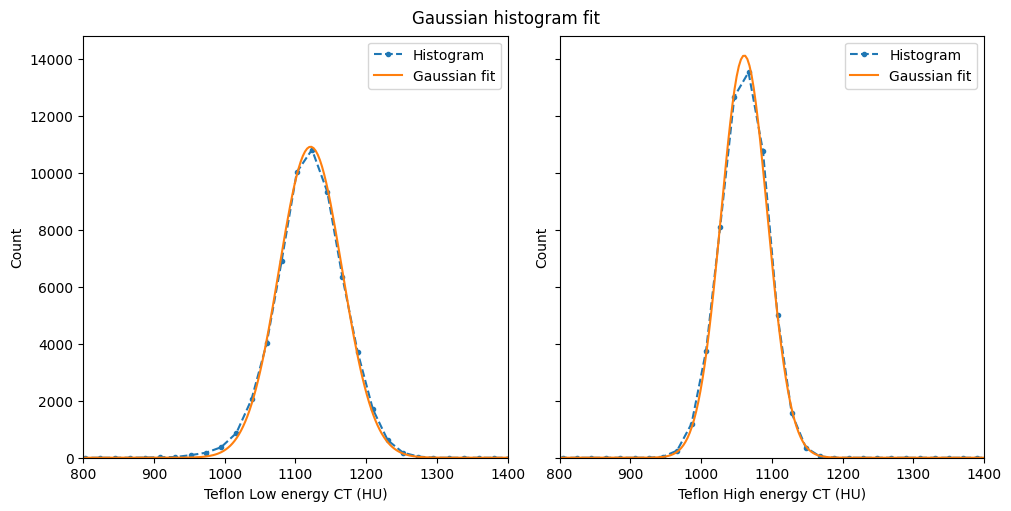

[output:0]

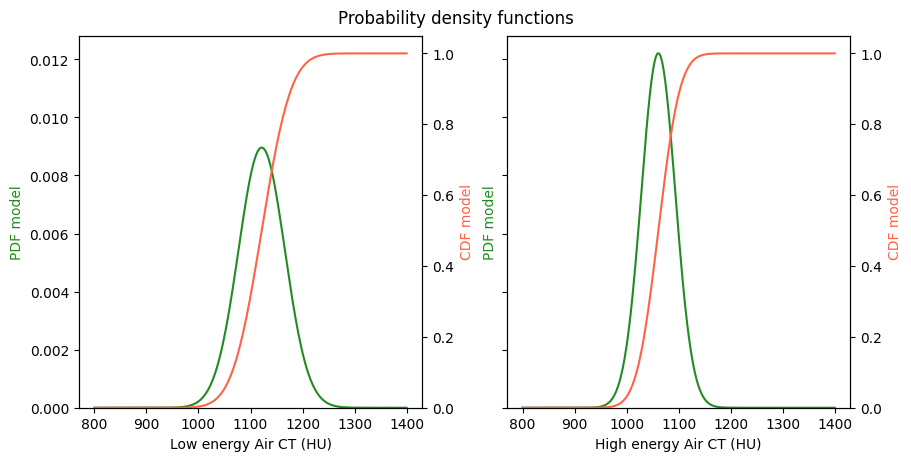

In [16]:
%%px --block

seg_phase = 4 # Teflon is segmentation phase 4
cm_index = 3  # We'll assign teflon to calibration material 3
name = 'Teflon'
bulk_density = 2.2
composition = {'C': 2, 'F': 4}

x_low = lowE_viewer.histogram.bin_centers
y_low = lowE_viewer.histogram.count[seg_phase].values
x_high = highE_viewer.histogram.bin_centers
y_high = highE_viewer.histogram.count[seg_phase].values

# Call gaussian_fit to get fitting parameters
c_low = gaussian_fit(x_low, y_low)
c_high = gaussian_fit(x_high, y_high)

# Build a fine-spaced histogram axis and call
# gaussian_val to build the gaussian curve.
# It is important to sample regions
# with PDF values close to zero
xlim = (800, 1400)
x_fit = np.linspace(*xlim, 200)
y_fit_low = gaussian_val(c_low, x_fit)
y_fit_high = gaussian_val(c_high, x_fit)

#Let's check the Gaussian fit:
if mpi_rank == 0:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5),
                           layout='constrained',
                           sharex=True, sharey=True)
    fig.suptitle('Gaussian histogram fit')

    for k, (x, y, yfit, E) in enumerate(zip((x_low, x_high),
                                            (y_low, y_high),
                                            (y_fit_low, y_fit_high),
                                            ('Low', 'High'))):

        ax[k].plot(x, y, '.--', label='Histogram')
        ax[k].plot(x_fit, yfit, '-', label='Gaussian fit')
        ax[k].set_xlabel(f'{name} {E} energy CT (HU)')
        ax[k].set_xlim(xlim)
        ax[k].legend()
        ax[k].set_ylabel('Count')
    ax[0].set_ylim(ymin=0)

# Now fill in necessary fields in dectgroup
# Note: setting or getting PDFs is a collective MPI call,
# make sure all the processes run it (e.g. don't use if 'mpi_rank == 0')
dectgroup.calibration_material[cm_index].description = name
dectgroup.calibration_material[cm_index].lowE_pdf = (x_fit, y_fit_low)
dectgroup.calibration_material[cm_index].highE_pdf = (x_fit, y_fit_high)
dectgroup.calibration_material[cm_index].bulk_density = bulk_density
dectgroup.calibration_material[cm_index].composition = composition

# RockVerse will normalize the PDF values before assigning them.
# Let's check that also (again, make sure all processes run these four lines)
x_lowE_pdf, y_lowE_pdf = dectgroup.calibration_material[cm_index].lowE_pdf
x_highE_pdf, y_highE_pdf = dectgroup.calibration_material[cm_index].highE_pdf
_, cdf_low = dectgroup.calibration_material[cm_index].lowE_cdf
_, cdf_high = dectgroup.calibration_material[cm_index].highE_cdf

if rv.config.mpi_rank == 0:
    fig, ax = plt.subplots(1, 2, figsize=(9, 4.5),
                           layout='constrained',
                           sharex=True, sharey=True)
    fig.suptitle('Probability density functions')

    for k, (x, y, c, E) in enumerate(zip((x_lowE_pdf, x_highE_pdf),
                                         (y_lowE_pdf, y_highE_pdf),
                                         (cdf_low, cdf_high),
                                         ('Low', 'High'))):
        ax[k].plot(x, y, color='forestgreen')
        ax[k].set_xlabel(f'{E} energy Air CT (HU)')
        ax[k].set_ylabel('PDF model', color='forestgreen')
        ax_cdf = ax[k].twinx()
        ax_cdf.plot(x, c, color='tomato')
        ax_cdf.set_ylabel('CDF model', color='tomato')
        ax_cdf.set_ylim(ymin=0)
    ax[0].set_ylim(ymin=0)

## Run the preprocessing step

Now we are ready to set the processing parameters and run the pre-processing step. Pre-processing will check all the necessary details in the ``dectgroup`` and pre-calculate the dual energy inversion coefficients. In case we need to resume an interrupted simulation, this step also verifies all the internal hash values to ensure simulation integrity.

Our little cluster with 8 MPI processes is still enough for this task. First let's take a look at the simulation parameters:

In [17]:
BETTER REFER TO DOCUMENTATION

SyntaxError: invalid syntax (1277716660.py, line 1)

In [ ]:
%%px --block

# Run the preprocessing step to check details and calculate inversion coefficients
dectgroup.preprocess()


### Appraisal

Let's take a look at the preprocessing results. This time, we will work locally instead of in the 
ipyparallel cluster, so we need to load the libraries and the DECT group here.

In [ ]:
# Note that we are not using the %%px cell magic here!
# The process will run locally, so we need to load
# the libraries and the dectgroup that we have not done so far

import matplotlib.pyplot as plt
import numpy as np
import rockverse as rv

# Load the DECT group
# dectgroup = rv.open(r'/path/to/dual_energy_ct/C04B21')
dectgroup = rv.open('/estgf_dados/P_D/GOB7/testemunhos/C04B21_DGX')


The pre-calculated inversion coefficients can be accessed through the following attributes:
- `lowE_inversion_coefficients`
- `highE_inversion_coefficients`

These attributes will output all the values as a Pandas DataFrame. Let's take a look at each one:


In [ ]:
print(dectgroup.lowE_inversion_coefficients)

In [ ]:
print(dectgroup.highE_inversion_coefficients)

Let's write some code to retrieve these parameters and display some plots:

In [ ]:
# Create subplots for low and high energy attenuation
fig1, ax1 = plt.subplots(2, 2, layout='constrained', figsize=(9, 4.5))
fig2, ax2 = plt.subplots(2, 2, layout='constrained', figsize=(9, 4.5))
fig1.suptitle('Monte Carlo Low Energy Attenuation')
fig2.suptitle('Monte Carlo High Energy Attenuation')

for ax, coef, mode in zip((ax1, ax2),
                          (dectgroup.lowE_inversion_coefficients,
                           dectgroup.highE_inversion_coefficients),
                          ('low', 'high')):
    for k, (i, j) in enumerate(zip((0, 0, 1, 1), (0, 1, 0, 1))):
        ax[i][j].hist(coef[f'CT_{k}'],
                      bins=50,
                      density=True,
                      facecolor='powderblue',
                      edgecolor='slategrey',
                      label='Histogram')
        ax[i][j].set_xlabel(dectgroup.calibration_material[k].description)
        ax[i][j].set_ylabel('pdf')
        x_pdf, y_pdf = dectgroup.calibration_material[k].__getattribute__(f'{mode}E_pdf')
        ax[i][j].plot(x_pdf, y_pdf, color='orange', label='input model')
        ax[i][j].legend()


In [ ]:
# Create subplots for $Z_{eff}$ histograms for low and high energy

fig1, axs = plt.subplots(2, 3, layout='constrained')
ax1 = axs[0][0], axs[0][1], axs[0][2]
ax2 = axs[1][0], axs[1][1], axs[1][2]
fig1.suptitle('Monte Carlo $Z_{eff}$ histograms')

for ax, coef, mode in (zip((ax1, ax2),
                           (dectgroup.lowE_inversion_coefficients,
                            dectgroup.highE_inversion_coefficients),
                            ('low', 'high'))):
    for k, xlb in enumerate(('Water', 'SiO2', 'Teflon')):
        ax[k].hist(coef[f'Z_{k+1}'],
                    bins=25,
                    density=True,
                    facecolor='powderblue',
                    edgecolor='slategrey',
                    label='Hist.')
        ax[k].set_title(f'{xlb}, {mode}E')
        ax[k].set_ylabel('count')
        ax[k].set_xlabel('$Z_{eff}$')


In [ ]:
# Create subplots for Monte Carlo inversion parameters for low and high energy

fig1, axs = plt.subplots(2, 3, layout='constrained')
ax1 = axs[0][0], axs[0][1], axs[0][2]
ax2 = axs[1][0], axs[1][1], axs[1][2]
fig1.suptitle('Monte Carlo Inversion parameters')

for ax, coef, mode in (zip((ax1, ax2),
                           (dectgroup.lowE_inversion_coefficients,
                            dectgroup.highE_inversion_coefficients),
                            ('low', 'high'))):
    for k, xlb in enumerate(('A', 'B', 'n')):
        ax[k].hist(coef[f'{xlb}'],
                    bins=25,
                    density=True,
                    facecolor='powderblue',
                    edgecolor='slategrey',
                    label='Hist.')
        ax[k].set_xlabel(f'{xlb}, {mode}E')
        ax[k].set_ylabel('count')

## Run the Monte Carlo inversion

Once we are satisfied with these inversion parameters, we are ready to run the full inversion. For this, we only need to execute the following code snippet in a parallel environment:

```python
import rockverse as rv
dectgroup = rv.open(r'/path/to/dual_energy_ct/C04B21')
dectgroup.run()
```

Remember: we are utilizing Monte Carlo in the Digital Rock universe! This process is computationally intensive and is meant to be run in a high-performance computing environment, such as a GPU-enabled machine or a handful of nodes in a CPU cluster. If you just want to test the inversion, you can go back to the mask definition and reduce the cylinder length to allow the code to work only on a tiny part of the whole image.

After completion, you will have access to the Monte Carlo results through the
following new voxel images as attributes of dectgroup:

- ``rho_min``: Voxel image with the minimum electron density per voxel.
- ``rho_p25``: Voxel image with the the first quartile for the electron density per voxel.
- ``rho_p50``: Voxel image with the the median values for the electron density per voxel.
- ``rho_p75``: Voxel image with the the third quartile for the electron density per voxel.
- ``rho_max``: Voxel image with the maximum electron density per voxel.
- ``Z_min``: Voxel image with the minimum effective atomic number per voxel.
- ``Z_p25``: Voxel image with the the first quartile for the effective atomic number per voxel.
- ``Z_p50``: Voxel image with the the median values for the effective atomic number per voxel.
- ``Z_p75``: Voxel image with the the third quartile for the effective atomic number per voxel.
- ``Z_max``: Voxel image with the maximum effective atomic number per voxel.
- ``valid``: Voxel image with the number of valid Monte Carlo results for each voxel.

In [ ]:
%%px --block

#MUST GO

dectgroup.required_iterations = 5000
rv.config.selected_gpus = []
dectgroup.run()

[stdout:0] [2025-02-19 16:47:12] Hashing Low attenuation: 100% 16/16 [00:00<00:00, 122.27chunk/s]
[2025-02-19 16:47:12] Hashing High attenuation: 100% 16/16 [00:00<00:00, 122.35chunk/s]
[2025-02-19 16:47:12] Hashing mask: 100% 16/16 [00:00<00:00, 334.00chunk/s]
[2025-02-19 16:47:12] Hashing segmentation: 100% 16/16 [00:00<00:00, 456.95chunk/s]
[2025-02-19 16:47:12] Calibration matrices up to date.
[2025-02-19 16:47:13] Creating output images: 11it [00:02,  5.06it/s]
[2025-02-19 16:47:15] Counting voxels: 100% 16/16 [00:08<00:00,  1.88chunk/s]
[2025-02-19 16:47:24] rho/Z inversion (chunk 5/16):   0% 8857/3387382 [04:26<61:24:21, 15.28voxel/s]

%px:   0%|          | 0/23 [00:00<?, ?tasks/s]